### Import pandas and read in the csv file and set it to a dataframe called baskets

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import collections



 -  make a function for preparing data, that
 - - read in data from a filename
 - - clean data: remove rows with NA's, convert "id" columns into categorical type
 - - make columns for date, year, month, day, hour, weekday, from the "placed_at" column

 - make a function that construct a new data frame for "merchants" from the basket data, that
 - - compute the total number of spending, number of orders, number of days, number of SKU's, number of top categories, number of sub categories
 - - total spent = sum of (quantity times price) 
 - - average spent per order = total spent divided by number of orders

In [18]:
def clean_data(baskets):
    baskets.dropna(inplace=True)
    for s in baskets.columns:
        if ("id" in s):
            baskets.loc[:,s] = pd.Categorical(baskets.loc[:,s])
    return baskets

def convert_date(baskets):
    baskets['datetime'] = baskets['placed_at'].apply(lambda x: datetime.fromisoformat(x))
    baskets['date'] = baskets['datetime'].dt.date
    baskets['year'] = baskets['datetime'].dt.year
    baskets['month'] = baskets['datetime'].dt.month
    baskets['day'] = baskets['datetime'].dt.day
    baskets['hour'] = baskets['datetime'].dt.hour
    baskets['weekday'] = baskets['datetime'].dt.weekday
    return(baskets)

def prep_data(filename):
    baskets = pd.read_csv(filename)
    baskets = clean_data(baskets)
    baskets = convert_date(baskets)
    return baskets

def make_merchants(baskets):
    baskets["spent"] = baskets["qty"] * baskets["price"]
    merchants = baskets.groupby(['merchant_id'])\
        .agg({'spent': 'sum', 
                'order_id': 'nunique', 
                'date': 'nunique', 
                'sku_id':'nunique', 
                'top_cat_id':'nunique', 
                'sub_cat_id':'nunique'})\
        .reset_index()\
        .rename(columns={'spent':'total_spent', 'order_id':'num_orders', 'date':'num_days', 'sku_id':'num_skus', 'top_cat_id':'num_top_cats', 'sub_cat_id':'num_sub_cats'})
    merchants['avg_spent_per_order'] = merchants.total_spent / merchants.num_orders
    return merchants
    

In [19]:
filename10 = 'new_baskets_sample_random_10.csv'
filename250 = 'new_baskets_sample_top_250.csv'
baskets10 = prep_data(filename10)
merchants10 = make_merchants(baskets10)
baskets250 = prep_data(filename250)
merchants250 = make_merchants(baskets250)

<AxesSubplot:>

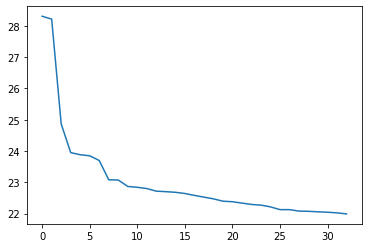

In [20]:
merchants10.avg_spent_per_order.sort_values(ascending=False).reset_index(drop=True).head(33).apply(lambda x: math.log(x,2)).plot()


<AxesSubplot:>

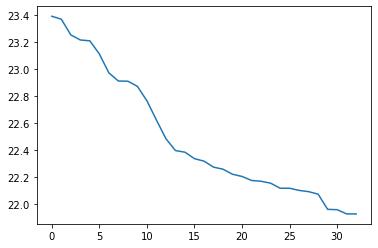

In [21]:
merchants250.avg_spent_per_order.sort_values(ascending=False).reset_index(drop=True).head(33).apply(lambda x: math.log(x,2)).plot()

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_spent_per_order', ylabel='Density'>

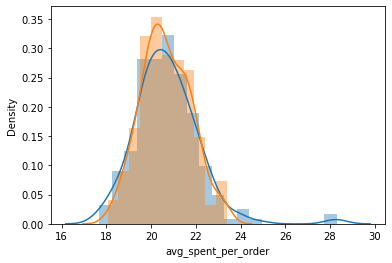

In [22]:
sns.distplot(merchants10.avg_spent_per_order.apply(lambda x: math.log(x,2)))
sns.distplot(merchants250.avg_spent_per_order.apply(lambda x: math.log(x,2)))

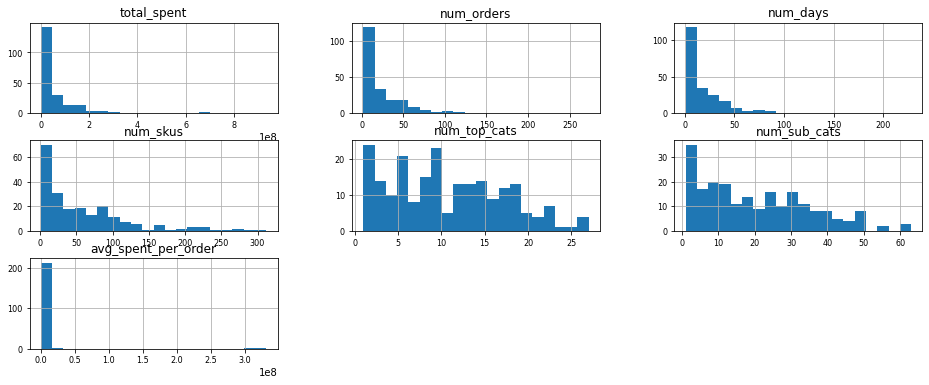

In [23]:
merchants10.hist(figsize=(16, 6), bins=20, xlabelsize=8, ylabelsize=8);

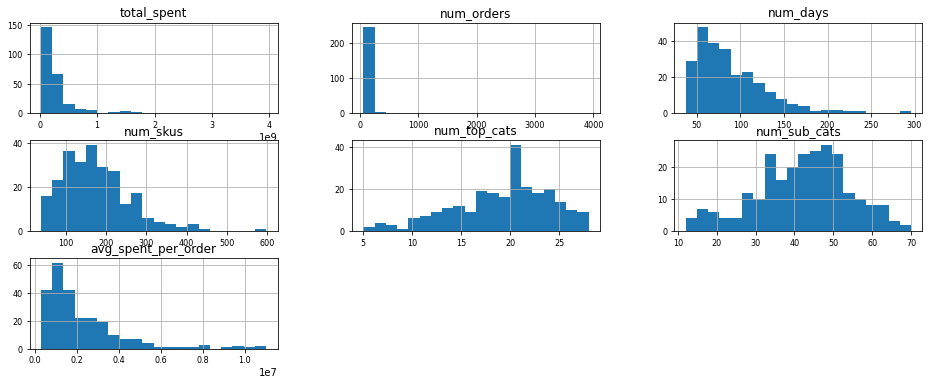

In [24]:
merchants250.hist(figsize=(16, 6), bins=20, xlabelsize=8, ylabelsize=8);

In [25]:
merchants10.loc[:,merchants10.columns[1:]].head()

,total_spent,num_orders,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order
0,36847750.0,44,40,53,11,23,8.374489e+05
1,162434400.0,39,34,312,27,60,4.164985e+06
2,66392500.0,38,34,115,18,37,1.747171e+06
3,451936800.0,51,42,288,26,62,8.861506e+06
4,40435000.0,16,14,38,13,19,2.527188e+06


In [26]:
merchants10.columns

Index(['merchant_id', 'total_spent', 'num_orders', 'num_days', 'num_skus',
       'num_top_cats', 'num_sub_cats', 'avg_spent_per_order'],
      dtype='object')

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

merchants_data = merchants10.loc[:,merchants10.columns[2:]]
stscaler = StandardScaler().fit(merchants_data)
normalized_df = stscaler.transform(merchants_data)

kmeans = KMeans(n_clusters=5, random_state=0).fit(normalized_df)
collections.Counter(kmeans.labels_)
#kmeans.cluster_centers_

Counter({1: 71, 2: 29, 0: 110, 3: 2, 4: 4})

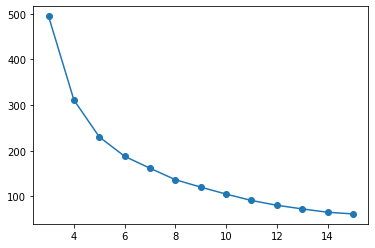

In [28]:
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
inertias = []
for c in clusters_range:
    kmeans = KMeans(init='k-means++',n_clusters=c,n_init=100, random_state=0).fit(normalized_df)
    inertias.append(kmeans.inertia_)
plt.figure()
plt.plot(clusters_range,inertias, marker='o')
plt.show()

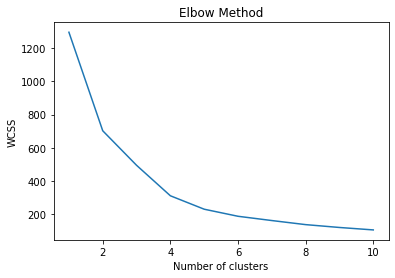

In [29]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(normalized_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [30]:
merchants_data.columns

Index(['num_orders', 'num_days', 'num_skus', 'num_top_cats', 'num_sub_cats',
       'avg_spent_per_order'],
      dtype='object')

In [31]:
import collections

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(normalized_df)

collections.Counter(pred_y)

Counter({1: 71, 2: 29, 0: 110, 3: 2, 4: 4})

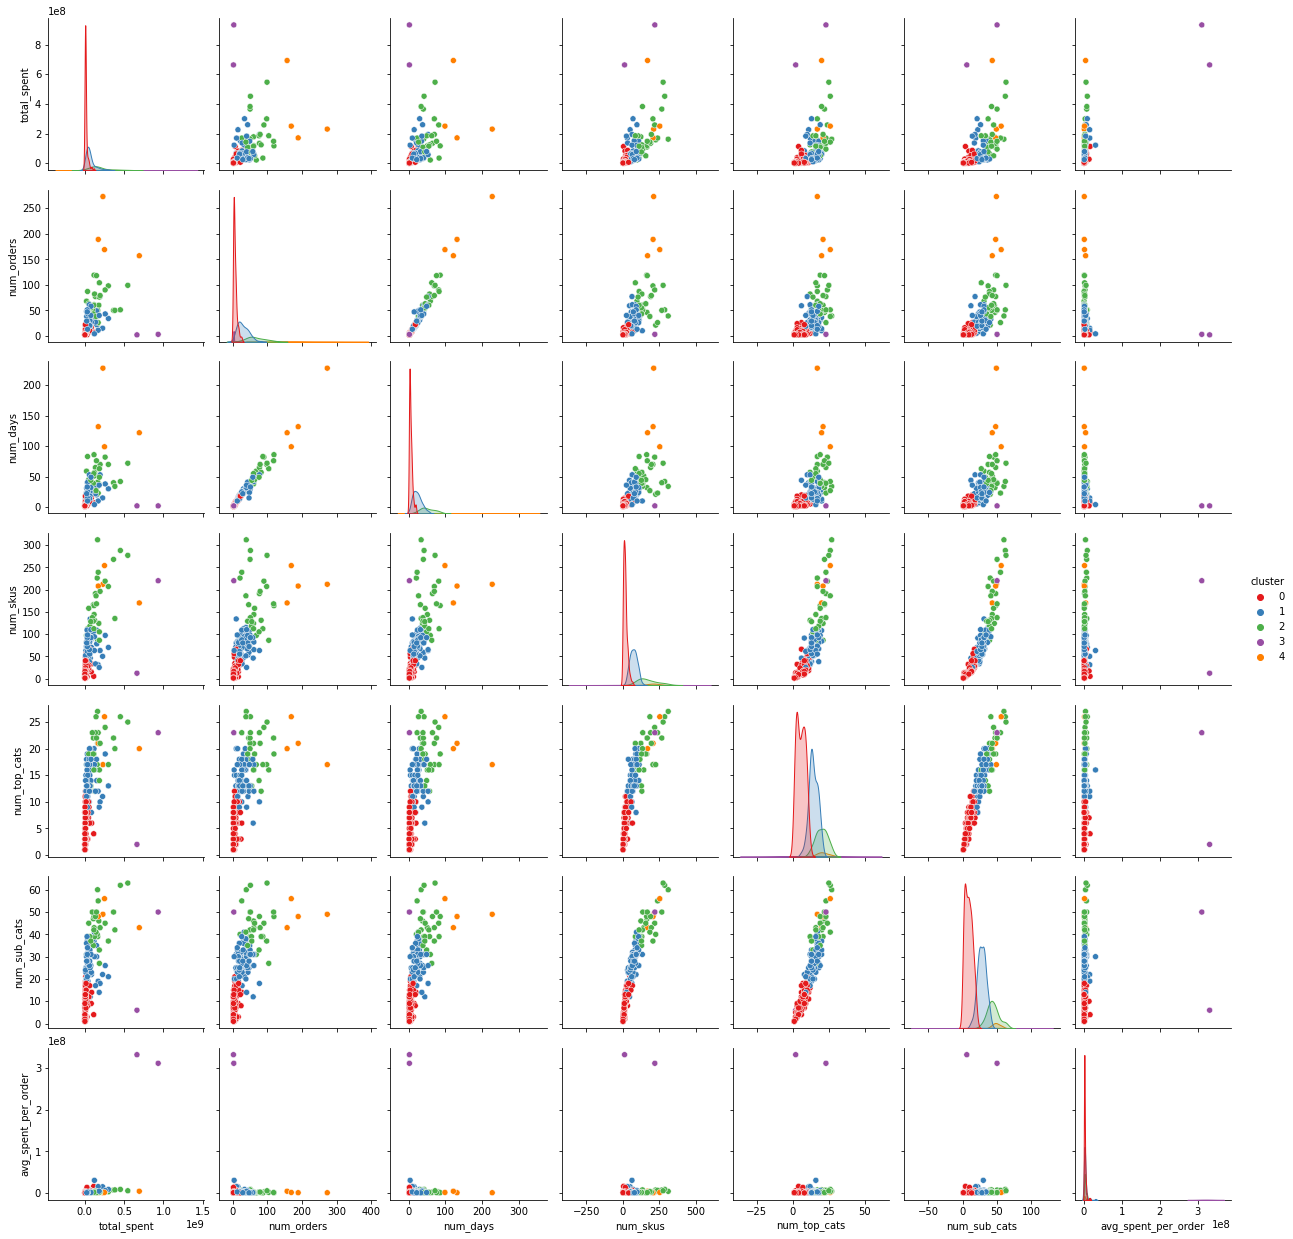

In [32]:
merchants10['cluster'] = pred_y
sns.pairplot(data=merchants10, hue="cluster", palette="Set1")


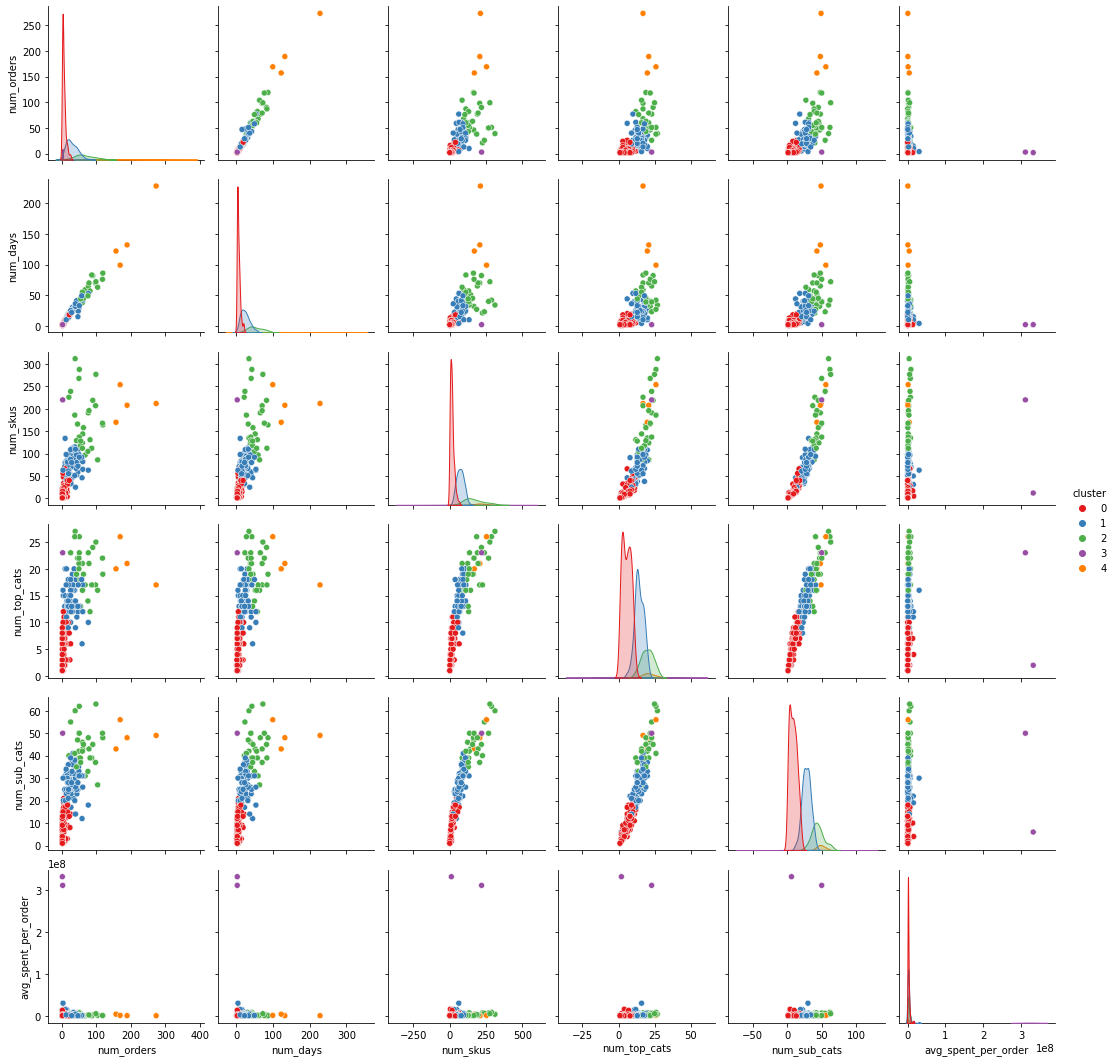

In [33]:
merchants_data['cluster'] = pred_y
sns.pairplot(data=merchants_data, hue="cluster", palette="Set1")


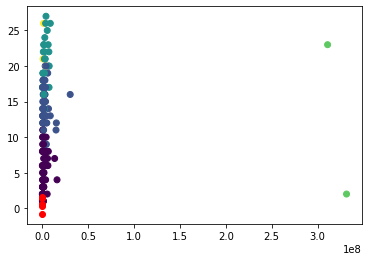

In [34]:

plt.scatter(merchants_data["avg_spent_per_order"], merchants_data["num_top_cats"],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:, 5], kmeans.cluster_centers_[:, 3], c='red')
plt.show()

In [35]:
kmeans.cluster_centers_

array([[-0.55761635, -0.561547  , -0.69425971, -0.79540584, -0.80709359,
        -0.11231952],
       [ 0.11619913,  0.1286388 ,  0.20842693,  0.55124953,  0.48018414,
        -0.07855065],
       [ 1.18728257,  1.19864564,  1.7319967 ,  1.4266213 ,  1.58552906,
        -0.0751986 ],
       [-0.65934365, -0.68322606,  0.89295446,  0.2861552 ,  0.51046757,
        10.28557363],
       [ 4.99378809,  4.81063586,  2.38911069,  1.60289944,  1.92148578,
        -0.11453619]])

In [36]:
merchants10.avg_spent_per_order.sort_values(ascending=False).reset_index(drop=True).head(33)

0     3.315550e+08
1     3.109242e+08
2     3.053188e+07
3     1.618636e+07
4     1.544450e+07
5     1.508480e+07
6     1.358975e+07
7     8.861506e+06
8     8.828454e+06
9     7.651960e+06
10    7.506240e+06
11    7.307820e+06
12    6.893045e+06
13    6.817950e+06
14    6.723083e+06
15    6.546569e+06
16    6.277580e+06
17    6.041058e+06
18    5.816812e+06
19    5.521657e+06
20    5.455000e+06
21    5.294070e+06
22    5.137581e+06
23    5.060335e+06
24    4.869600e+06
25    4.581500e+06
26    4.577088e+06
27    4.432567e+06
28    4.412720e+06
29    4.363678e+06
30    4.323175e+06
31    4.263907e+06
32    4.164985e+06
Name: avg_spent_per_order, dtype: float64

<AxesSubplot:>

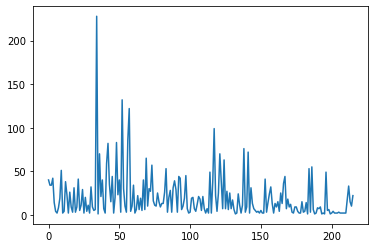

In [37]:
merchants10.num_days.plot()

<AxesSubplot:>

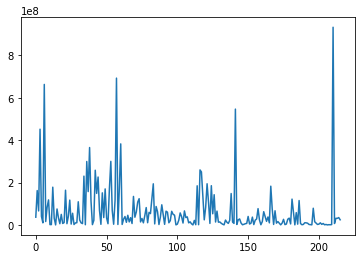

In [38]:
merchants10.total_spent.plot()

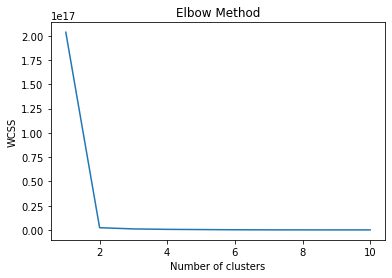

In [39]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(merchants_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

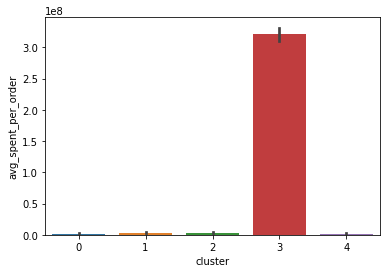

In [40]:
ax = sns.barplot(x="cluster", y="avg_spent_per_order", data=merchants_data)

### cluster 3 looks like containing merchants who have high average spending per orders.

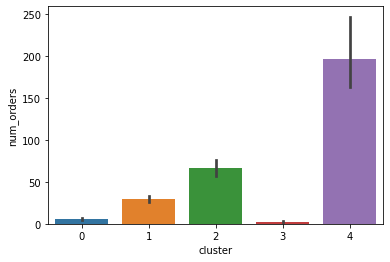

In [41]:
ax = sns.barplot(x="cluster", y="num_orders", data=merchants_data)

<Figure size 1080x720 with 0 Axes>

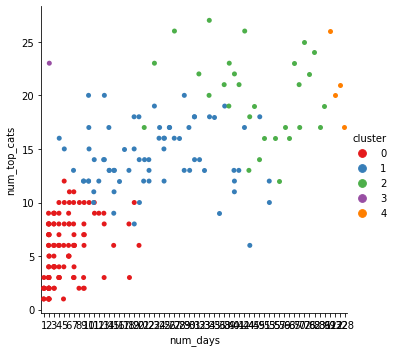

In [42]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_top_cats",data=merchants_data, hue="cluster", palette="Set1")

<Figure size 1080x720 with 0 Axes>

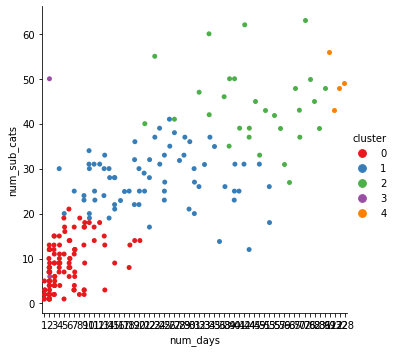

In [43]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_sub_cats",data=merchants_data, hue="cluster", palette="Set1")

<Figure size 1080x720 with 0 Axes>

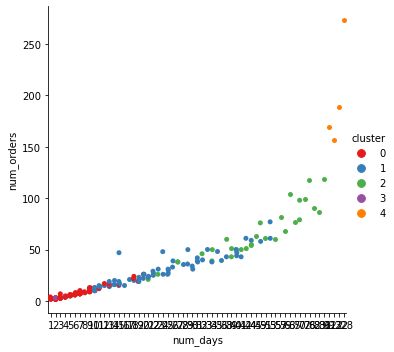

In [44]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_orders",data=merchants_data, hue="cluster", palette="Set1")

<Figure size 1080x720 with 0 Axes>

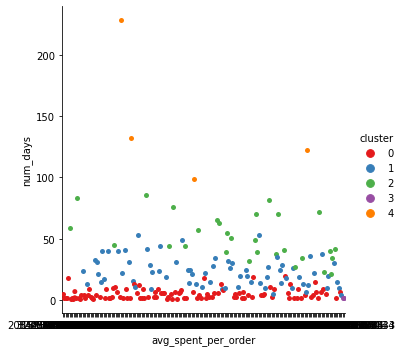

In [45]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="avg_spent_per_order", y = "num_days",data=merchants_data, hue="cluster", palette="Set1")

### cluster 4 consists of the merchants that have high number of days, 4 of them all above 100?


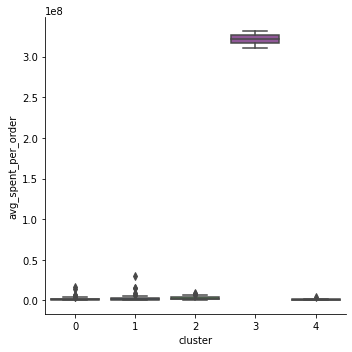

In [46]:
ax = sns.catplot(x="cluster", y = "avg_spent_per_order", data=merchants_data, palette="Set1", kind="box")

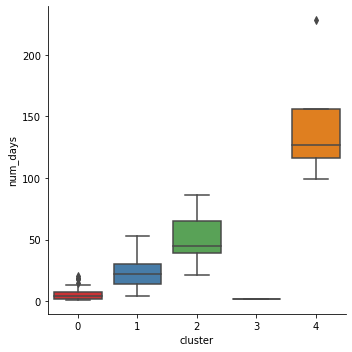

In [47]:
ax = sns.catplot(x="cluster", y = "num_days", data=merchants_data, palette="Set1", kind="box")

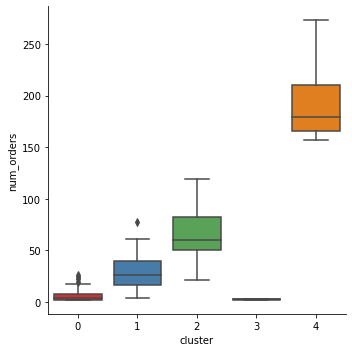

In [48]:
ax = sns.catplot(x="cluster", y = "num_orders", data=merchants_data, palette="Set1", kind="box")

In [49]:
merchants_data.columns

Index(['num_orders', 'num_days', 'num_skus', 'num_top_cats', 'num_sub_cats',
       'avg_spent_per_order', 'cluster'],
      dtype='object')

In [50]:
merchants10.columns

Index(['merchant_id', 'total_spent', 'num_orders', 'num_days', 'num_skus',
       'num_top_cats', 'num_sub_cats', 'avg_spent_per_order', 'cluster'],
      dtype='object')

<Figure size 1080x720 with 0 Axes>

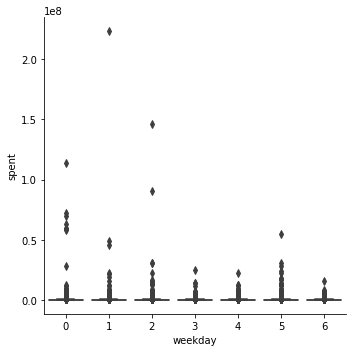

In [51]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="weekday", y = "spent",data=baskets10, palette="Set1",kind="box")